In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D
from keras.optimizers import Adam
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__

'2.9.1'

In [3]:
data = 'datasets/'
No_BT = 'datasets/no/'
Yes_BT = 'datasets/yes/'

In [4]:
dirlist = [No_BT, Yes_BT]
classes = ['No', 'Yes']
filepaths = []
labels = []

for i, j in zip(dirlist, classes):
    filelist = os.listdir(i)
    for f in filelist:
        filepath = os.path.join(i,f)
        filepaths.append(filepath)
        labels.append(j)
        
print('Total images and Labels in the directory:')        
print('Filepaths:', len(filepaths), 'Labels:', len(labels))

Total images and Labels in the directory:
Filepaths: 3086 Labels: 3086


In [5]:
Files = pd.Series(filepaths, name='Filepaths')
Labels = pd.Series(labels, name='Labels')

df = pd.concat([Files, Labels], axis=1)
df = pd.DataFrame(np.array(df).reshape(3086,2), columns=['Filepaths', 'Labels'])
df.head()

,Filepaths,Labels
0,datasets/no/1 no.jpeg,No
1,datasets/no/10 no.jpg,No
2,datasets/no/11 no.jpg,No
3,datasets/no/12 no.jpg,No
4,datasets/no/13 no.jpg,No


In [6]:
df['Labels'].value_counts()  # Number of images available in yes and No

No     1586
Yes    1500
Name: Labels, dtype: int64

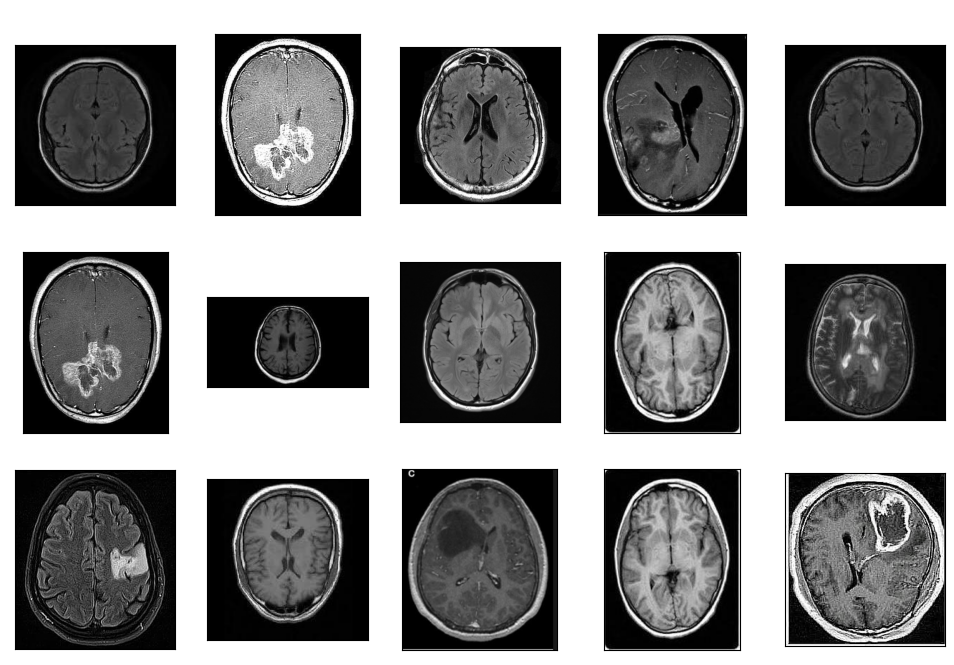

In [7]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1, len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,'Filepaths']))
    plt.title(df.loc[random, 'Labels'], size = 15, color = 'white')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
# Splitting data into train and test
train, test = train_test_split(df, train_size=0.85, random_state=0)
train_new, valid = train_test_split(train, train_size=0.80, random_state=0)

print(f"Train shape: {train_new.shape}")
print(f"Test shape: {test.shape}")
print(f"Validation shape: {valid.shape}")

Train shape: (2098, 2)
Test shape: (463, 2)
Validation shape: (525, 2)


In [9]:
# train and test data generation-- train augumentation and test augumentation
train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  shear_range=0.2, zoom_range=0.2,
                                  horizontal_flip=True, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

In [10]:
train_gen = train_datagen.flow_from_dataframe(dataframe=train_new,
                                             x_col='Filepaths', y_col='Labels',
                                             target_size= (224,224), batch_size=32,
                                             class_mode='binary', shuffle=True)

val_gen = train_datagen.flow_from_dataframe(dataframe=valid,
                                             x_col='Filepaths', y_col='Labels',
                                             target_size= (224,224), batch_size=16,
                                             class_mode='binary', shuffle=True)

test_gen = test_datagen.flow_from_dataframe(dataframe=test,
                                             x_col='Filepaths', y_col='Labels',
                                             target_size= (224,224), batch_size=16,
                                             class_mode='binary', shuffle=False)

Found 2098 validated image filenames belonging to 2 classes.
Found 525 validated image filenames belonging to 2 classes.
Found 463 validated image filenames belonging to 2 classes.


In [11]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [12]:
base_model = keras.applications.ResNet50V2(weights='imagenet',
                                          input_shape=(224,224,3),
                                          include_top = False,)
# freeze the base_model
base_model.trainable = False

#create new model on top
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) #Regularize with Dropout
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_____________________________________________

In [19]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("BrainTumor_classifier_model.h5",
                                              save_best_only=True, verbose=0)]

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[callbacks], verbose=1)

Epoch 1/100
66/66 [==============================] - 182s 3s/step - loss: 0.7168 - accuracy: 0.5777 - val_loss: 0.6281 - val_accuracy: 0.6229
Epoch 2/100
66/66 [==============================] - 169s 3s/step - loss: 0.6166 - accuracy: 0.6592 - val_loss: 0.5374 - val_accuracy: 0.7295
Epoch 3/100
66/66 [==============================] - 169s 3s/step - loss: 0.5530 - accuracy: 0.7035 - val_loss: 0.5105 - val_accuracy: 0.7505
Epoch 4/100
66/66 [==============================] - 170s 3s/step - loss: 0.5086 - accuracy: 0.7512 - val_loss: 0.4484 - val_accuracy: 0.8114
Epoch 5/100
66/66 [==============================] - 168s 3s/step - loss: 0.4811 - accuracy: 0.7679 - val_loss: 0.4269 - val_accuracy: 0.8267
Epoch 6/100
66/66 [==============================] - 169s 3s/step - loss: 0.4619 - accuracy: 0.7774 - val_loss: 0.4009 - val_accuracy: 0.8552
Epoch 7/100
66/66 [==============================] - 105s 2s/step - loss: 0.4326 - accuracy: 0.8036 - val_loss: 0.3878 - val_accuracy: 0.8571
Epoch 

In [20]:
model.save('BrainTumor_classifier_model1.h5')

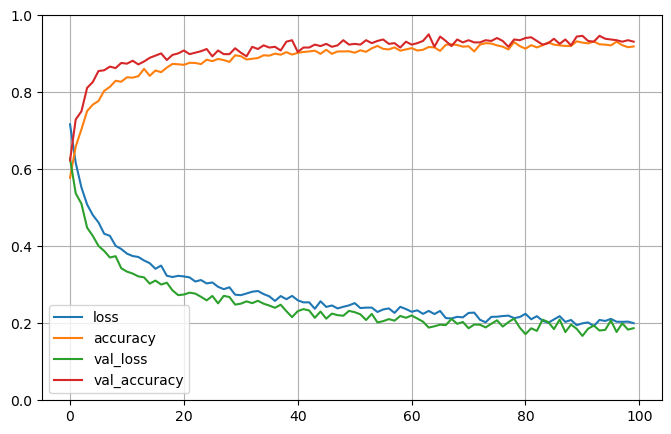

In [21]:
#Evaluating the model
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

1/1 [==============================] - 1s 1s/step
YES, Have Brain tumor


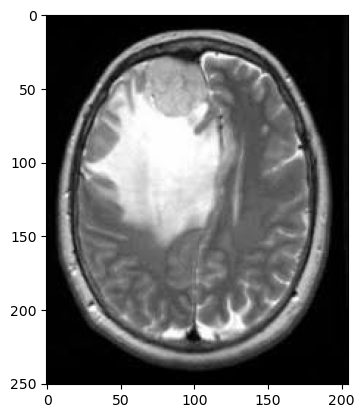

In [18]:
model_path = 'BrainTumor_classifier_model1.h5'
loaded_model = tf.keras.models.load_model(model_path)

image = cv2.imread("D:\sharan personal\PES(M.TECH)\MTech Project\Brain_Tumor\Brain_Tumor_Tensorflow_keras\pred\pred5.jpg")
plt.imshow(image)

image_fromarray = Image.fromarray(image,'RGB')
resize_image = image_fromarray.resize((224,224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred>=0.5:
    print('YES, Have Brain tumor')
else:
    print('Dont have Brain Tumor')     